In [1]:
!pip install pandas==1.5.3 numpy==1.24.3 scikit-learn==1.0.2 matplotlib==3.7.1 seaborn==0.12.2 joblib==1.1.0 openpyxl==3.1.2 xlrd==2.0.1 google-generativeai==0.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 45.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
import sys
sys.path

['/content',
 '/env/python',
 '/usr/lib/python311.zip',
 '/usr/lib/python3.11',
 '/usr/lib/python3.11/lib-dynload',
 '',
 '/usr/local/lib/python3.11/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.11/dist-packages/IPython/extensions',
 '/root/.ipython']

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import joblib
import os

WCZYTANIE I EKSPLORACJA DANYCH
Wczytano dane z pliku CSV (.csv)

Informacje o zbiorze danych:
Liczba próbek: 299
Liczba cech: 12

Statystyki opisowe:
              age     anaemia  creatinine_phosphokinase    diabetes  \
count  299.000000  299.000000                299.000000  299.000000   
mean    60.833893    0.431438                581.839465    0.418060   
std     11.894809    0.496107                970.287881    0.494067   
min     40.000000    0.000000                 23.000000    0.000000   
25%     51.000000    0.000000                116.500000    0.000000   
50%     60.000000    0.000000                250.000000    0.000000   
75%     70.000000    1.000000                582.000000    1.000000   
max     95.000000    1.000000               7861.000000    1.000000   

       ejection_fraction  high_blood_pressure      platelets  \
count         299.000000           299.000000     299.000000   
mean           38.083612             0.351171  263358.029264   
std            11.

<ipython-input-4-ca8b68288fa0>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='DEATH_EVENT', data=df, palette=['green', 'red'])


Macierz korelacji zapisana jako: correlation_matrix.png

Najsilniejsze korelacje z DEATH_EVENT:
serum_creatinine: 0.294
age: 0.254
high_blood_pressure: 0.079
anaemia: 0.066
creatinine_phosphokinase: 0.063
diabetes: -0.002
sex: -0.004
smoking: -0.013
platelets: -0.049
serum_sodium: -0.195
ejection_fraction: -0.269
time: -0.527
Histogramy cech zapisane jako: feature_distributions.png


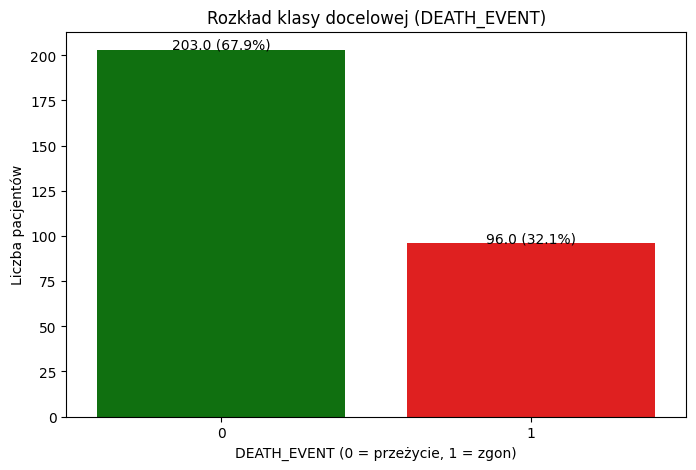

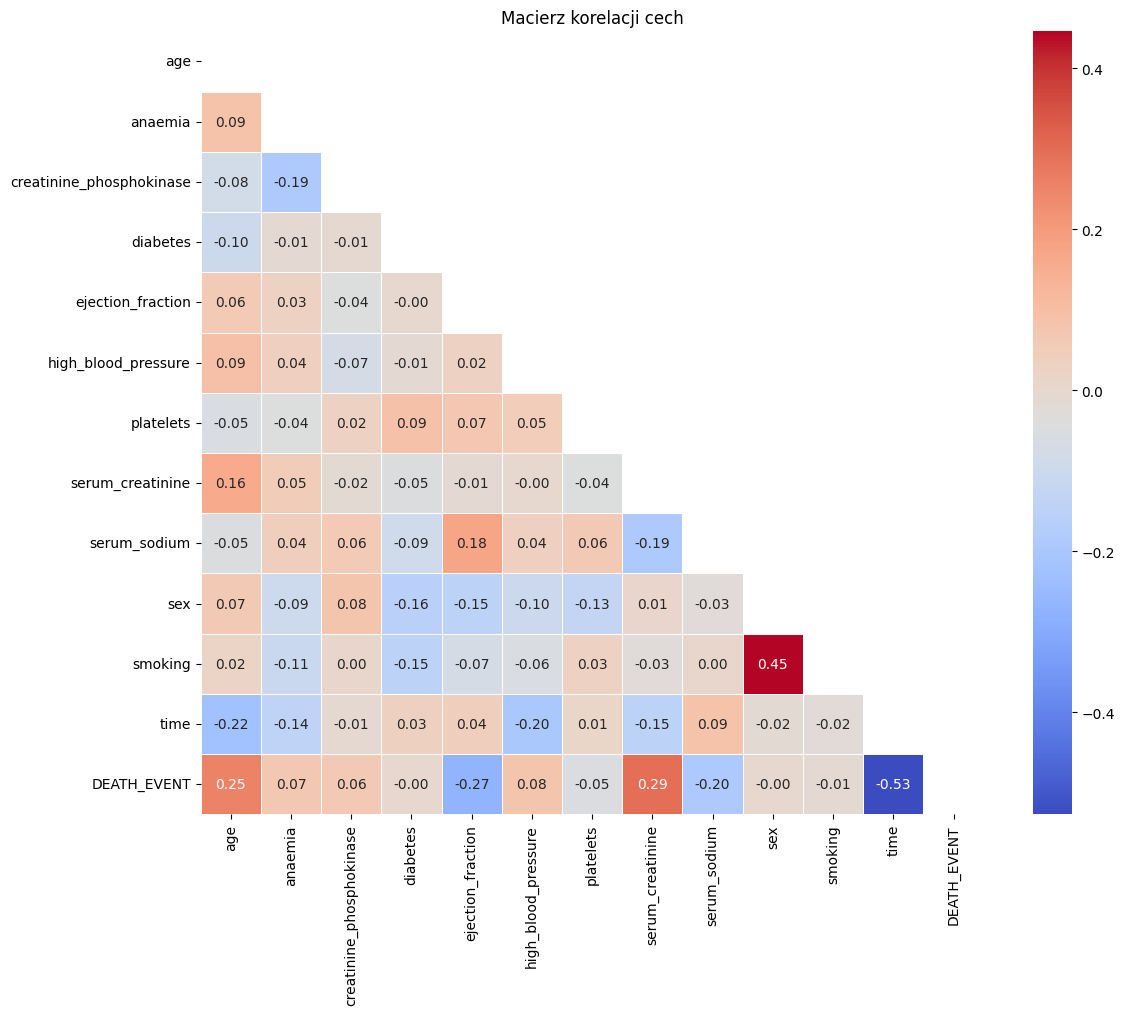

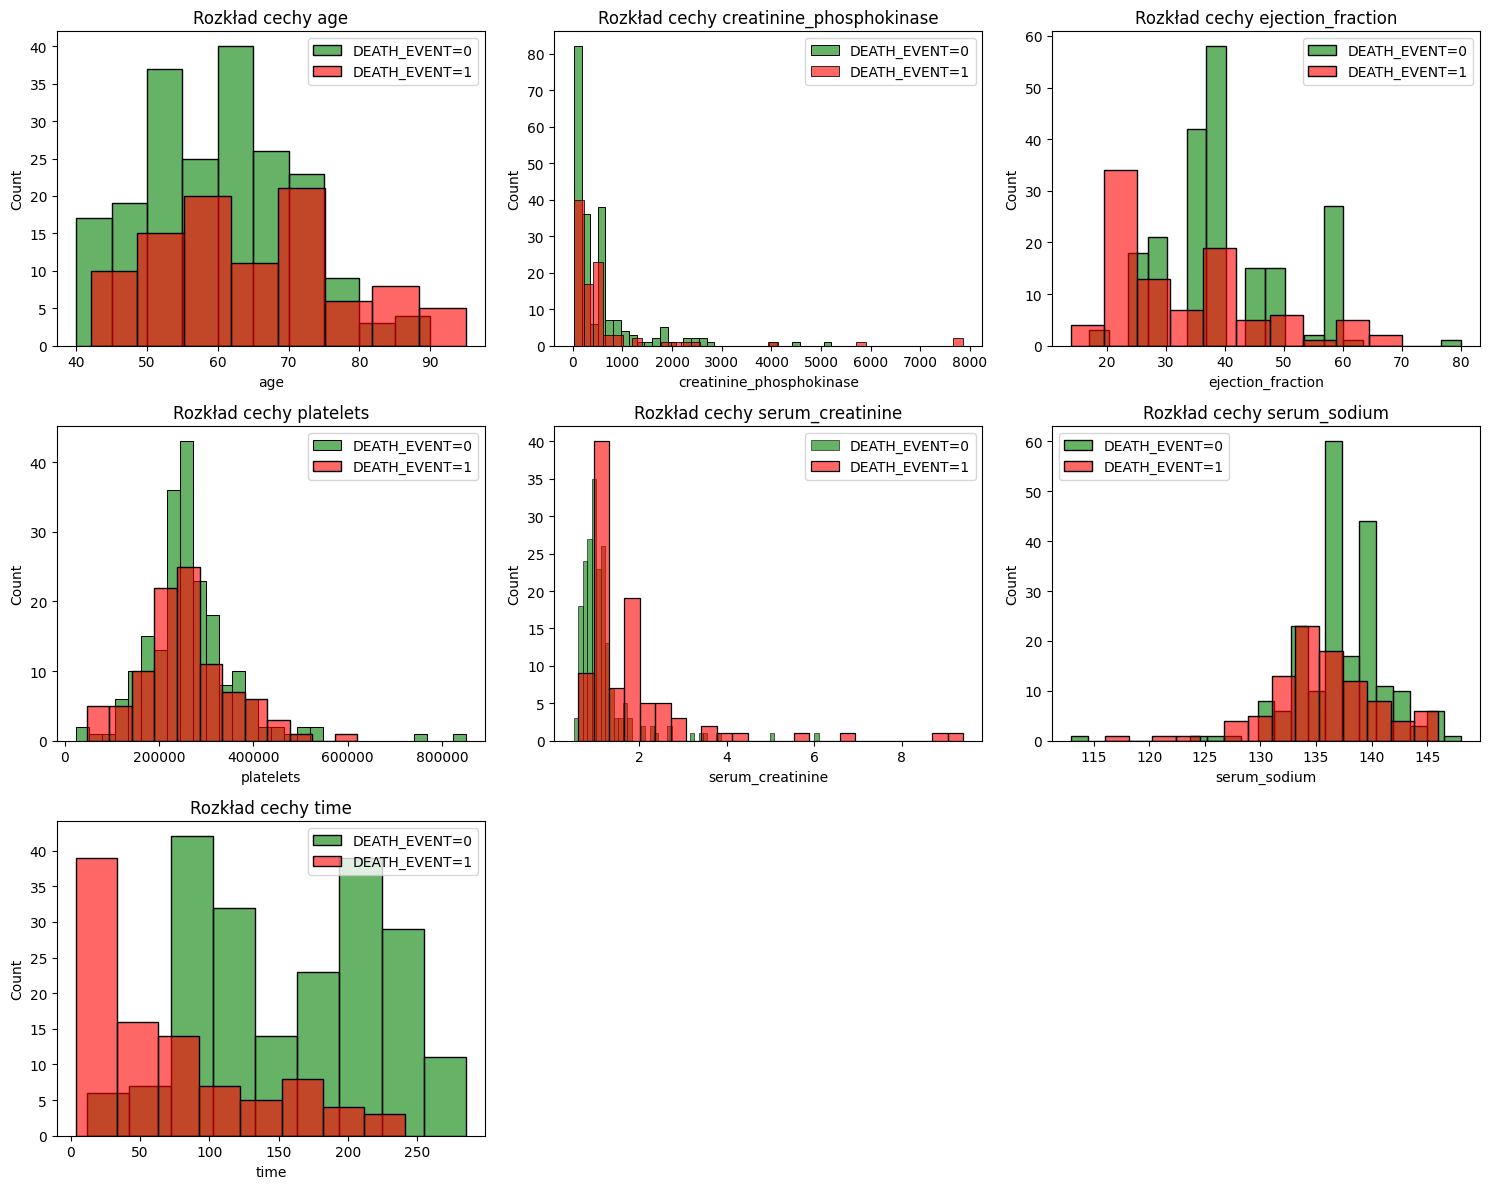

In [4]:
# ----- 1. WCZYTANIE I EKSPLORACJA DANYCH -----
print("=" * 50)
print("WCZYTANIE I EKSPLORACJA DANYCH")
print("=" * 50)

# Wczytanie danych
try:
    df = pd.read_excel('heart_failure_clinical_records_dataset.xls')
    print("Wczytano dane z pliku Excel (.xls)")
except:
    try:
        df = pd.read_csv('/content/heart_failure_clinical_records_dataset.csv')
        print("Wczytano dane z pliku CSV (.csv)")
    except:
        raise Exception("Nie można znaleźć pliku z danymi")

# Podstawowe informacje o zbiorze danych
print("\nInformacje o zbiorze danych:")
print(f"Liczba próbek: {df.shape[0]}")
print(f"Liczba cech: {df.shape[1] - 1}")  # minus kolumna z etykietami

# Statystyki opisowe
print("\nStatystyki opisowe:")
print(df.describe())

# Sprawdzenie brakujących wartości
print("\nLiczba brakujących wartości w każdej kolumnie:")
print(df.isnull().sum())

# Rozkład klas
death_count = df['DEATH_EVENT'].sum()
survival_count = len(df) - death_count
death_percentage = (death_count / len(df)) * 100

print(f"\nRozkład klasy docelowej (DEATH_EVENT):")
print(f"Przeżycie: {survival_count} próbek ({100-death_percentage:.1f}%)")
print(f"Zgon: {death_count} próbek ({death_percentage:.1f}%)")

# Wizualizacja rozkładu klas
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='DEATH_EVENT', data=df, palette=['green', 'red'])
plt.title('Rozkład klasy docelowej (DEATH_EVENT)')
plt.xlabel('DEATH_EVENT (0 = przeżycie, 1 = zgon)')
plt.ylabel('Liczba pacjentów')

# Dodanie etykiet na słupkach
for p in ax.patches:
    ax.annotate(f'{p.get_height()} ({p.get_height()/len(df)*100:.1f}%)',
                (p.get_x() + p.get_width()/2., p.get_height() + 0.5),
                ha='center')

plt.savefig('class_distribution.png')
print("Wykres rozkładu klas zapisany jako: class_distribution.png")

# Macierz korelacji i mapa ciepła
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', square=True, linewidths=.5)
plt.title('Macierz korelacji cech')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
print("Macierz korelacji zapisana jako: correlation_matrix.png")

# Wyświetlenie najsilniejszych korelacji z DEATH_EVENT
death_corr = correlation_matrix['DEATH_EVENT'].drop('DEATH_EVENT').sort_values(ascending=False)
print("\nNajsilniejsze korelacje z DEATH_EVENT:")
for feature, corr in death_corr.items():
    print(f"{feature}: {corr:.3f}")

# Histogramy dla cech numerycznych
numerical_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction',
                      'platelets', 'serum_creatinine', 'serum_sodium', 'time']

plt.figure(figsize=(15, 12))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)
    for target, color in zip([0, 1], ['green', 'red']):
        sns.histplot(df[df['DEATH_EVENT'] == target][feature],
                     color=color, label=f'DEATH_EVENT={target}', alpha=0.6)
    plt.title(f'Rozkład cechy {feature}')
    plt.xlabel(feature)
    plt.legend()
plt.tight_layout()
plt.savefig('feature_distributions.png')
print("Histogramy cech zapisane jako: feature_distributions.png")

In [5]:
# # ----- 1. WCZYTANIE I EKSPLORACJA DANYCH -----
# print("=" * 50)
# print("WCZYTANIE I EKSPLORACJA DANYCH")
# print("=" * 50)

# # Wczytanie danych
# try:
#     df = pd.read_csv('/content/heart_failure_clinical_records_dataset.csv')
#     print("Wczytano dane z pliku CSV (.csv)")
# except:
#     raise Exception("Nie można znaleźć pliku z danymi")

# # Podstawowe informacje o zbiorze danych
# print("\nInformacje o zbiorze danych:")
# print(f"Liczba próbek: {df.shape[0]}")
# print(f"Liczba cech: {df.shape[1] - 1}")  # minus kolumna z etykietami

# # Statystyki opisowe
# print("\nStatystyki opisowe:")
# print(df.describe())

# # Sprawdzenie brakujących wartości
# print("\nLiczba brakujących wartości w każdej kolumnie:")
# print(df.isnull().sum())

# # Rozkład klas
# death_count = df['DEATH_EVENT'].sum()
# survival_count = len(df) - death_count
# death_percentage = (death_count / len(df)) * 100

# print(f"\nRozkład klasy docelowej (DEATH_EVENT):")
# print(f"Przeżycie: {survival_count} próbek ({100-death_percentage:.1f}%)")
# print(f"Zgon: {death_count} próbek ({death_percentage:.1f}%)")

# # Wizualizacja rozkładu klas
# plt.figure(figsize=(8, 5))
# ax = sns.countplot(x='DEATH_EVENT', data=df)
# plt.title('Rozkład klasy docelowej (DEATH_EVENT)')
# plt.xlabel('DEATH_EVENT (0 = przeżycie, 1 = zgon)')
# plt.ylabel('Liczba pacjentów')

# # Dodanie etykiet na słupkach
# for p in ax.patches:
#     ax.annotate(f'{p.get_height()} ({p.get_height()/len(df)*100:.1f}%)',
#                 (p.get_x() + p.get_width()/2., p.get_height() + 0.5),
#                 ha='center')

# plt.tight_layout()
# plt.savefig('class_distribution.png')
# print("Wykres rozkładu klas zapisany jako: class_distribution.png")

# # Macierz korelacji i mapa ciepła
# plt.figure(figsize=(12, 10))
# correlation_matrix = df.corr()
# sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
# plt.title('Macierz korelacji cech')
# plt.tight_layout()
# plt.savefig('correlation_matrix.png')
# print("Macierz korelacji zapisana jako: correlation_matrix.png")


In [6]:
# ----- 2. PRZYGOTOWANIE DANYCH -----
print("\n" + "=" * 50)
print("PRZYGOTOWANIE DANYCH")
print("=" * 50)

# Podział na cechy i etykiety
X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Rozmiar zbioru treningowego: {X_train.shape[0]} próbek")
print(f"Rozmiar zbioru testowego: {X_test.shape[0]} próbek")

# Standaryzacja cech
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


PRZYGOTOWANIE DANYCH
Rozmiar zbioru treningowego: 239 próbek
Rozmiar zbioru testowego: 60 próbek



TRENOWANIE MODELU

Ważność cech:
time: 0.3614
serum_creatinine: 0.1541
ejection_fraction: 0.1291
platelets: 0.0768
age: 0.0768
creatinine_phosphokinase: 0.0745
serum_sodium: 0.0662
diabetes: 0.0139
high_blood_pressure: 0.0134
sex: 0.0113
anaemia: 0.0112
smoking: 0.0112
Wykres ważności cech zapisany jako: feature_importance.png


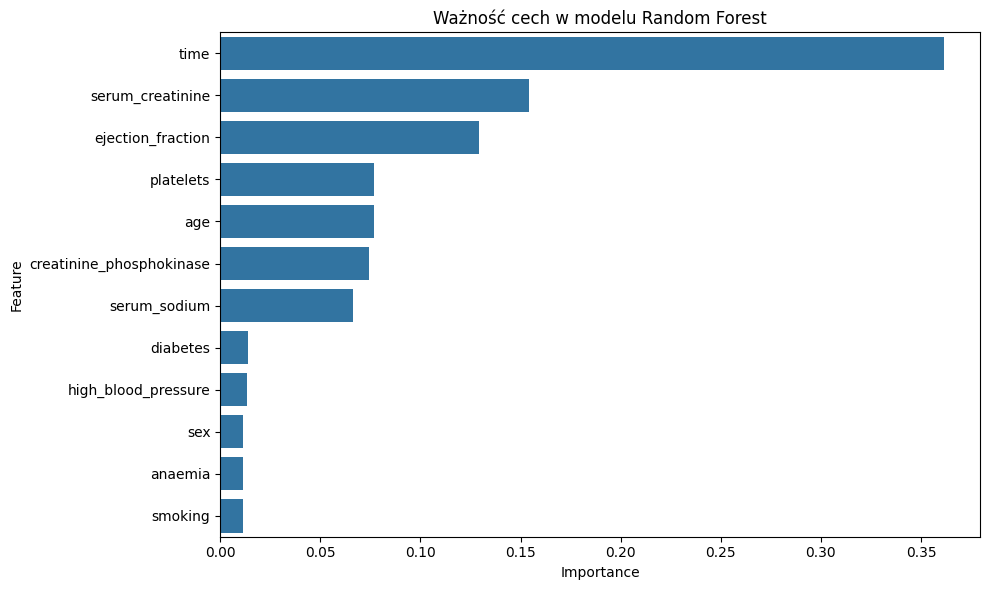

In [7]:
# ----- 3. TRENOWANIE MODELU -----
print("\n" + "=" * 50)
print("TRENOWANIE MODELU")
print("=" * 50)

# Trenowanie modelu RandomForest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Ważność cech
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nWażność cech:")
for idx, row in feature_importance.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

# Wizualizacja ważności cech
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Ważność cech w modelu Random Forest')
plt.tight_layout()
plt.savefig('feature_importance.png')
print("Wykres ważności cech zapisany jako: feature_importance.png")


EWALUACJA MODELU
Dokładność na zbiorze testowym: 0.8333
Macierz konfuzji zapisana jako: confusion_matrix.png

Raport klasyfikacji:
              precision    recall  f1-score   support

   Przeżycie       0.84      0.93      0.88        41
        Zgon       0.80      0.63      0.71        19

    accuracy                           0.83        60
   macro avg       0.82      0.78      0.79        60
weighted avg       0.83      0.83      0.83        60

Krzywa ROC zapisana jako: roc_curve.png


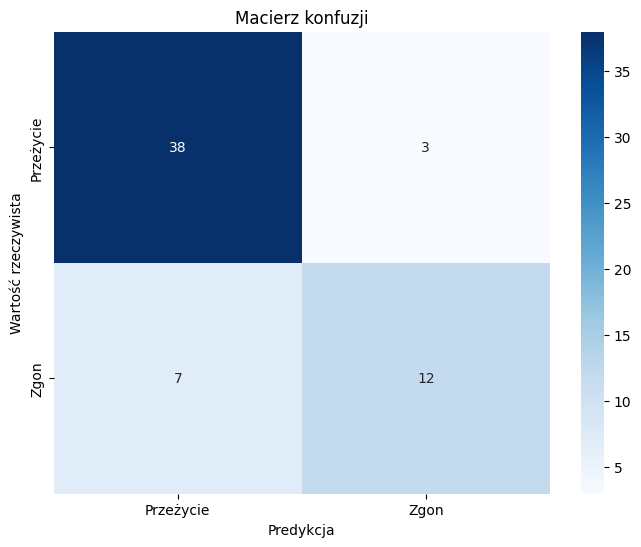

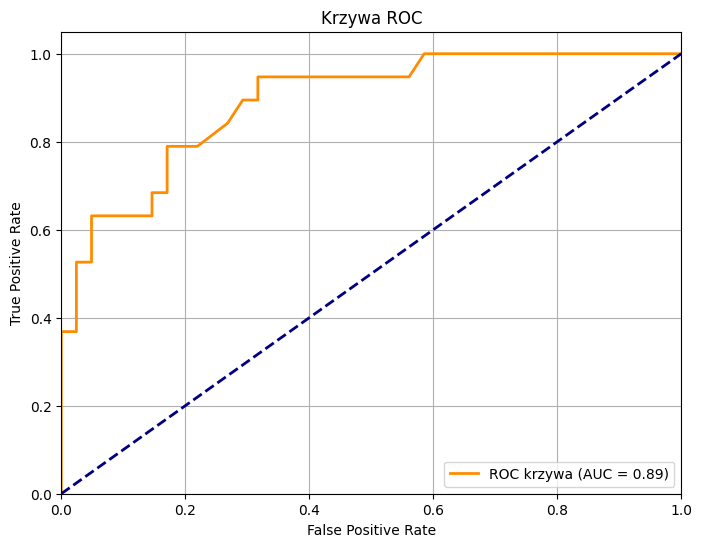

In [8]:
# ----- 4. EWALUACJA MODELU -----
print("\n" + "=" * 50)
print("EWALUACJA MODELU")
print("=" * 50)

# Predykcje na zbiorze testowym
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Dokładność
accuracy = (y_pred == y_test).mean()
print(f"Dokładność na zbiorze testowym: {accuracy:.4f}")

# Macierz konfuzji
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Przeżycie', 'Zgon'],
            yticklabels=['Przeżycie', 'Zgon'])
plt.title('Macierz konfuzji')
plt.xlabel('Predykcja')
plt.ylabel('Wartość rzeczywista')
plt.savefig('confusion_matrix.png')
print("Macierz konfuzji zapisana jako: confusion_matrix.png")

# Raport klasyfikacji
print("\nRaport klasyfikacji:")
report = classification_report(y_test, y_pred, target_names=['Przeżycie', 'Zgon'])
print(report)

# Krzywa ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krzywa (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('roc_curve.png')
print("Krzywa ROC zapisana jako: roc_curve.png")

In [9]:
# ----- 5. ZAPISANIE MODELU -----
print("\n" + "=" * 50)
print("ZAPISANIE MODELU")
print("=" * 50)

# Zapisanie modelu
joblib.dump(model, 'model.joblib', compress=3)
print("Model zapisany jako: model.joblib")

# Zapisanie skalera
joblib.dump(scaler, 'scaler.joblib')
print("Skaler zapisany jako: scaler.joblib")

# Zapisanie informacji o cechach
feature_ranges = {}
for column in X.columns:
    if df[column].nunique() <= 2:  # binarna zmienna
        feature_ranges[column] = [0, 1]
    else:  # zmienna ciągła
        feature_ranges[column] = [float(df[column].min()), float(df[column].max())]

feature_info = {
    'names': X.columns.tolist(),
    'ranges': feature_ranges
}

import json
with open('feature_info.json', 'w') as f:
    json.dump(feature_info, f, indent=2)
print("Informacje o cechach zapisane jako: feature_info.json")

print("\nTrening i ewaluacja modelu zakończone pomyślnie.")
print("Wyniki analizy:")
print(f"- Dokładność: {accuracy:.4f}")
print(f"- AUC: {roc_auc:.4f}")
print("\nWygenerowane wykresy:")
print("1. class_distribution.png - Rozkład klas")
print("2. correlation_matrix.png - Macierz korelacji")
print("3. confusion_matrix.png - Macierz konfuzji")
print("4. roc_curve.png - Krzywa ROC")
print("5. feature_importance.png - Ważność cech")

print("\nWszystko gotowe do użycia w aplikacji!")


ZAPISANIE MODELU
Model zapisany jako: model.joblib
Skaler zapisany jako: scaler.joblib
Informacje o cechach zapisane jako: feature_info.json

Trening i ewaluacja modelu zakończone pomyślnie.
Wyniki analizy:
- Dokładność: 0.8333
- AUC: 0.8909

Wygenerowane wykresy:
1. class_distribution.png - Rozkład klas
2. correlation_matrix.png - Macierz korelacji
3. confusion_matrix.png - Macierz konfuzji
4. roc_curve.png - Krzywa ROC
5. feature_importance.png - Ważność cech

Wszystko gotowe do użycia w aplikacji!
